# Deep Learning Graphs and Metrics

In [1]:
!nvidia-smi

Thu Nov 26 12:35:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:0A:00.0  On |                  N/A |
|  0%   43C    P0    81W / 250W |    343MiB / 11016MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [1]:
#Utilities
import numpy as np
import time
import time as tm

#Visualizers
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
import matplotlib.pyplot as plt

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef

#Model and others
import tensorflow as tf
from sklearn.model_selection  import train_test_split
import numpy
import random
import os
import matplotlib.colors as colors
import cv2
from keras import backend as K
import glob
from skimage.util.shape import view_as_blocks
from keras.utils import np_utils
from keras.utils import to_categorical


#USE OF CPU, WHEN IS NOT AVAILABLE THE GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Dataset

In [3]:
n=256
def load_images(path_pattern):
    files=glob.glob(path_pattern)
    X=[]
    for f in sorted(files):
        I = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        patches = view_as_blocks(I, (n, n))
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                X.append( [ patches[i,j] ] )
    X=numpy.array(X)
    return X

main_path= './DATABASES/BOSSbase-1.01'
pathc = main_path
paths = main_path+'/WOW/0.4bpp'

Xc_ = load_images(pathc+'/cover/*.pgm') ##COVER IMAGES
Xs_ = load_images(paths+'/stego/*.pgm') ##STEGO IMAGES
X_  = (numpy.vstack((Xc_, Xs_)))
Xt_ = (numpy.hstack(([0]*len(Xc_), [1]*len(Xs_))))
Xt_ = np_utils.to_categorical(Xt_, 2)
X_  = np.rollaxis(X_,1,4)  #channel axis shifted to last axis

print("Total image data and labels",X_.shape,Xt_.shape)
#Cover hasta las 10000 ##Train hasta las 4000 ##Valid hasta de las 4000 a las 5000 ##Test de las 5000 a las 10000
X_train =  np.concatenate([X_[0:4000], X_[10000:14000]],axis=0)
y_train = np.concatenate([Xt_[0:4000],Xt_[10000:14000]],axis=0)
X_valid =  np.concatenate([X_[4000:5000], X_[14000:15000]],axis=0)
y_valid = np.concatenate([Xt_[4000:5000],Xt_[14000:15000]],axis=0)
X_test  =  np.concatenate([X_[5000:10000], X_[15000:20000]],axis=0)
y_test  = np.concatenate([Xt_[5000:10000],Xt_[15000:20000]],axis=0)
#Controled randomized data for training
X_dat0, X_dat1, y_dat0, y_dat1 = train_test_split(X_train, y_train, test_size=0.50, random_state=64) 
X_train = np.concatenate([X_dat0,X_dat1],axis=0) 
y_train = np.concatenate([y_dat0,y_dat1],axis=0) 
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

Total image data and labels (20000, 256, 256, 1) (20000, 2)
(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


cover


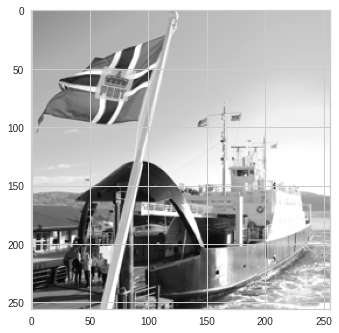

stego


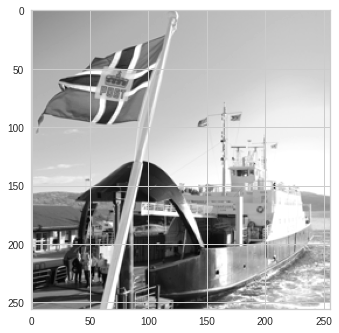

cover


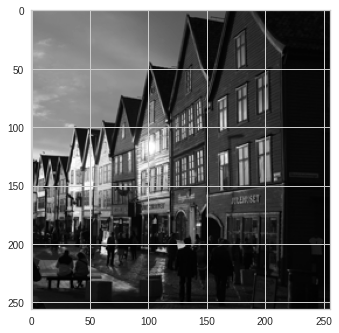

stego


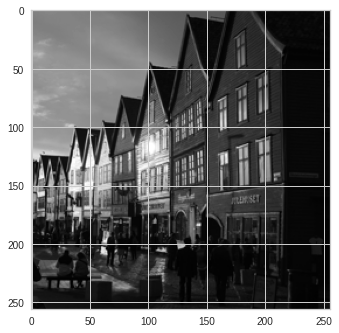

In [4]:
for i in range(1,3,1):
    plt.figure()
    print("cover")
    plt.imshow(X_test[i,:,:,0],cmap='gray')
    plt.show()
    plt.figure()
    print("stego")
    plt.imshow(X_test[5000+i,:,:,0],cmap='gray')
    plt.show()


# Model

In [5]:
################################################## 30 SRM FILTERS
srm_weights = np.load('./SRM_Kernels1.npy') 
biasSRM=numpy.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################

(5, 5, 1, 30)


In [6]:
def GBRAS_Net():
    tf.keras.backend.clear_session()
    #Inputs
    inputs = tf.keras.Input(shape=(256,256,1), name="input_1")
    #Layer 1
    layers = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), padding='same', trainable=False, activation=Tanh3, use_bias=True)(inputs)
    layers1 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 2
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers1)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 3
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers)
    layers = tf.keras.layers.SeparableConv2D(30,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers2 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    skip1 =   tf.keras.layers.Add()([layers1, layers2])
    #Layer 4
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(skip1) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 5
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 6
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 7
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers3 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 8
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers3)
    layers = tf.keras.layers.SeparableConv2D(60,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 9
    layers = tf.keras.layers.DepthwiseConv2D(1)(layers)
    layers = tf.keras.layers.SeparableConv2D(60,(3,3), padding='same', activation="elu",depth_multiplier=3)(layers) 
    layers4 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    skip2 =   tf.keras.layers.Add()([layers3, layers4])
    #Layer 10
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(skip2) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 11
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 12
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 13
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 14
    layers = tf.keras.layers.Conv2D(60, (3,3), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 15
    layers = tf.keras.layers.AveragePooling2D((2,2), strides= (2,2))(layers)
    #Layer 16
    layers = tf.keras.layers.Conv2D(30, (1,1), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 17
    layers = tf.keras.layers.Conv2D(2, (1,1), strides=(1,1), activation="elu", padding='same', kernel_initializer='glorot_uniform')(layers) 
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    #Layer 18
    layers = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")(layers)
    #Layer 19
    predictions = tf.keras.layers.Softmax(axis=1)(layers)
    #Model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    #Optimizer
    optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    print ("Model GBRAS-Net Generated")
    #Model compilation
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
path_log = './Trained_Models' 
model_name = '/WOW_0.4bpp.hdf5'
model = tf.keras.models.load_model(path_log+model_name, custom_objects={'Tanh3':Tanh3}, compile=True)

In [14]:
y_pred = model.predict(X_test) 


In [15]:
y_pred

array([[0.6346501 , 0.36534986],
       [0.74320304, 0.25679693],
       [0.6566226 , 0.34337744],
       ...,
       [0.43503216, 0.5649679 ],
       [0.30576068, 0.6942393 ],
       [0.59483993, 0.4051601 ]], dtype=float32)

In [16]:
def score_ci(
    y_true,
    y_pred,
    score_fun,
    n_bootstraps=2000,
    confidence_level=0.95,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute confidence interval for given score function based on labels and predictions using bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_pred: 1D list or array of predictions corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param confidence_level: Confidence level for computing confidence interval. (default: 0.95)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Score evaluated on labels and predictions, lower confidence interval, upper confidence interval, array of
    bootstrapped scores.
    """

    assert len(y_true) == len(y_pred)

    score = score_fun(y_true, y_pred)
    _, ci_lower, ci_upper, scores = score_stat_ci(
        y_true=y_true,
        y_preds=y_pred,
        score_fun=score_fun,
        n_bootstraps=n_bootstraps,
        confidence_level=confidence_level,
        seed=seed,
        reject_one_class_samples=reject_one_class_samples,
    )

    return score, ci_lower, ci_upper, scores


def score_stat_ci(
    y_true,
    y_preds,
    score_fun,
    stat_fun=np.mean,
    n_bootstraps=2000,
    confidence_level=0.95,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute confidence interval for given statistic of a score function based on labels and predictions using
    bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_preds: A list of lists or 2D array of predictions corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param stat_fun: Statistic for which confidence interval is computed. (e.g. np.mean)
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param confidence_level: Confidence level for computing confidence interval. (default: 0.95)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Mean score statistic evaluated on labels and predictions, lower confidence interval, upper confidence
    interval, array of bootstrapped scores.
    """

    y_true = np.array(y_true)
    y_preds = np.atleast_2d(y_preds)
    assert all(len(y_true) == len(y) for y in y_preds)

    np.random.seed(seed)
    scores = []
    for i in range(n_bootstraps):
        readers = np.random.randint(0, len(y_preds), len(y_preds))
        indices = np.random.randint(0, len(y_true), len(y_true))
        if reject_one_class_samples and len(np.unique(y_true[indices])) < 2:
            continue
        reader_scores = []
        for r in readers:
            reader_scores.append(score_fun(y_true[indices], y_preds[r][indices]))
        scores.append(stat_fun(reader_scores))

    mean_score = np.mean(scores)
    sorted_scores = np.array(sorted(scores))
    alpha = (1.0 - confidence_level) / 2.0
    ci_lower = sorted_scores[int(round(alpha * len(sorted_scores)))]
    ci_upper = sorted_scores[int(round((1.0 - alpha) * len(sorted_scores)))]
    return mean_score, ci_lower, ci_upper, scores


def pvalue(
    y_true,
    y_pred1,
    y_pred2,
    score_fun,
    n_bootstraps=2000,
    two_tailed=True,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute p-value for hypothesis that score function for model I predictions is higher than for model II predictions
    using bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_pred1: 1D list or array of predictions for model I corresponding to elements in y_true.
    :param y_pred2: 1D list or array of predictions for model II corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param two_tailed: Whether to use two-tailed test. (default: True)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Computed p-value, array of bootstrapped differences of scores.
    """

    assert len(y_true) == len(y_pred1)
    assert len(y_true) == len(y_pred2)

    return pvalue_stat(
        y_true=y_true,
        y_preds1=y_pred1,
        y_preds2=y_pred2,
        score_fun=score_fun,
        n_bootstraps=n_bootstraps,
        two_tailed=two_tailed,
        seed=seed,
        reject_one_class_samples=reject_one_class_samples,
    )


def pvalue_stat(
    y_true,
    y_preds1,
    y_preds2,
    score_fun,
    stat_fun=np.mean,
    n_bootstraps=2000,
    two_tailed=True,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute p-value for hypothesis that given statistic of score function for model I predictions is higher than for
    model II predictions using bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_preds1: A list of lists or 2D array of predictions for model I corresponding to elements in y_true.
    :param y_preds2: A list of lists or 2D array of predictions for model II corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param stat_fun: Statistic for which p-value is computed. (e.g. np.mean)
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param two_tailed: Whether to use two-tailed test. (default: True)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Computed p-value, array of bootstrapped differences of scores.
    """

    y_true = np.array(y_true)
    y_preds1 = np.atleast_2d(y_preds1)
    y_preds2 = np.atleast_2d(y_preds2)
    assert all(len(y_true) == len(y) for y in y_preds1)
    assert all(len(y_true) == len(y) for y in y_preds2)

    np.random.seed(seed)
    z = []
    for i in range(n_bootstraps):
        readers1 = np.random.randint(0, len(y_preds1), len(y_preds1))
        readers2 = np.random.randint(0, len(y_preds2), len(y_preds2))
        indices = np.random.randint(0, len(y_true), len(y_true))
        if reject_one_class_samples and len(np.unique(y_true[indices])) < 2:
            continue
        reader_scores = []
        for r in readers1:
            reader_scores.append(score_fun(y_true[indices], y_preds1[r][indices]))
        score1 = stat_fun(reader_scores)
        reader_scores = []
        for r in readers2:
            reader_scores.append(score_fun(y_true[indices], y_preds2[r][indices]))
        score2 = stat_fun(reader_scores)
        z.append(score1 - score2)

    p = percentileofscore(z, 0.0, kind="weak") / 100.0
    if two_tailed:
        p *= 2.0
    return p, z

In [27]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#https://github.com/BioAITeam/Steganalysis/blob/main/MV.py
#https://github.com/BioAITeam/Steganalysis/blob/main/GBRAS-Net.ipynb
#https://github.com/mateuszbuda/ml-stat-util/blob/master/stat_util.py
#https://pubs.rsna.org/doi/pdf/10.1148/radiol.2020202944

def ROC_curves(y_test,y_score,name, path_img_base = './images'):
    if not os.path.exists(path_img_base):
        os.makedirs(path_img_base)
    n_classes = y_test.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    

    # Plot ROC curve
    plt.figure(figsize=(10, 10))
    
       
    for i in range(n_classes):
        score, ci_lower, ci_upper, scores = score_ci(y_test[:, i], y_score[:, i], 
                                                       score_fun=roc_auc_score,
                                                       seed=42)

        plt.plot(fpr[i], tpr[i], 
                 label="ROC curve of class {:.0f}, AUC of {:.3f} (95% CI: {:.3f}, {:.3f})".format(i, score, ci_lower, ci_upper))
    
    #plt.plot(fpr["micro"], tpr["micro"],
    #         label='micro-average ROC curve (AUC = {0:0.3f})'.format(roc_auc["micro"]),
    #         color='aqua', linestyle=':', linewidth=4)

    #plt.plot(fpr["macro"], tpr["macro"],
    #         label='macro-average ROC curve (AUC = {0:0.3f})'.format(roc_auc["macro"]),
    #         color='darkorange', linestyle=':', linewidth=4)


    plt.plot([0, 1], [0, 1], linestyle=":", c=LINE_COLOR) 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curves for {}".format(name))
    plt.legend(loc="lower right", frameon=True)
    plt.savefig(path_img_base+'/ROC_CI_graphs_per_class_'+name+'.svg', format='svg') 
    plt.savefig(path_img_base+'/ROC_CI_graphs_per_class_'+name+'.pdf', format='pdf') 
    plt.show()

In [28]:
y_score = y_pred

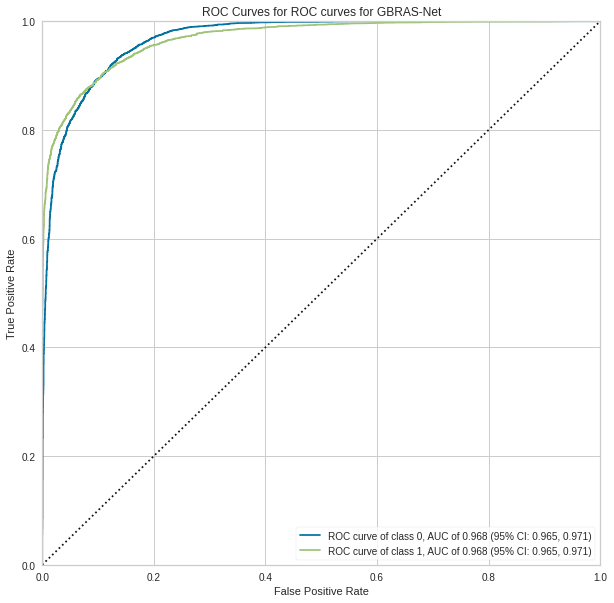

In [29]:
import yellowbrick
from yellowbrick.style.palettes import LINE_COLOR
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

name = "ROC curves for GBRAS-Net"
path = "./ROC_AUC_CI"
ROC_curves(y_test,y_score,name,path_img_base=path)